# <span align="center">Quantifying The World Case Study Unit 8 - Stock Price ARIMA Time Series Prediction</span>
### <span align="right">Ryan Bass and Brett Benefield </span>
### <span align="right">March 7, 2019</span>

# Introduction
Since the stock market was created, the demand to accurately predict future fluctuations in prices has been paramount for investors. The more accurate a forecast, the more investors can profit. We will be pulling Coca-Cola's stock price data starting from January 1st, 2014 to February 1st, 2018. We will be utilizing ARIMA (Autoregressive Integrated Moving Average) to fit a model to the collected time series data of the stock prices to forecast future prices.

ARIMA is a combination of three models; autoregressive, integrated, and moving average. These models weigh past results in the time series, the differences between the past results, and the average of those previous results. Although ARIMA is a combination of three models, it is fairly simple to tune due to it only haveing three parameters (Autoregressive: p, Integrated: d, and Moving average: q). A drawback comes in its strict assumptions that need to be met. The time series has to use linear time, have no trends, and no seasonal patterns. This excludes many, many time series, including basically all stock price time series.

Text(0, 0.5, 'Share Price')

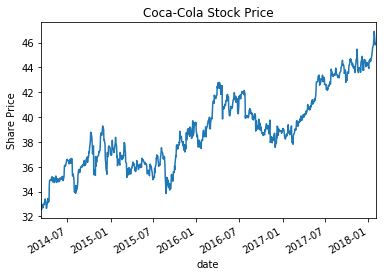

In [3]:
colaPrice.plot()
plt.title("Coca-Cola Stock Price")
plt.ylabel("Share Price")

Figure 1 - Coca-Cola Stock Price from 2014 to 2018.

# Methods

### Error metric

One metric that can be used to compare the performance of one model over another is the Akaike Information Criteria (AIC) metric. A good model should include enough features that it minimizes the difference between the predicted value and the actual value (assuming we have a train and test set of data). However, too many features can lead to overfitting the data and the model loses its ability to generalize well to new data. To find a balance between these two scenarios, the AIC metric tries to minimize the predicted error while penalizing models for including features that do not help explain any extra varaibility in the data. In other words, the AIC metric tries to minimize the predicted error value and minimize the number of features included in the model. The lower the value of the AIC score, the better the model performs over other competing models.

### Stationary Assumption

A way to determine if a time series is stationary (meaning it does not have trends) is to look for statistical significance in the Dickey-Fuller Test. We will calculate the critical value for 90, 95, and 99 percent confidence and if our test statistic is less than any of those thresholds then our data is stationary.

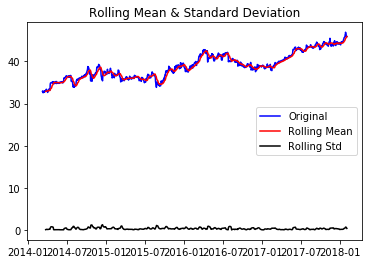

Results of Dickey-Fuller Test:
Test Statistic                  -1.439089
p-value                          0.563400
#Lags Used                       0.000000
Number of Observations Used    983.000000
Critical Value (1%)             -3.437020
Critical Value (5%)             -2.864485
Critical Value (10%)            -2.568338
dtype: float64


In [14]:
test_stationarity(colaPrice)

Figure 2 - Dickey-Fuller Test on Coca-Cola Stock Prices. Stationary assumption is violated and needs to be rectified.

With a test statistic of -1.439089, and a 90% confidence (critical value = -2.568) we fail to reject the null hypothesis that our data is not stationary. However, using ARIMA is still possible on this data if we can subtract the rolling mean and subtract it from the data to help apease the stationary requirement. We'll try to subtract the rolling average of the previous 6 data points and test our data for stationary again.

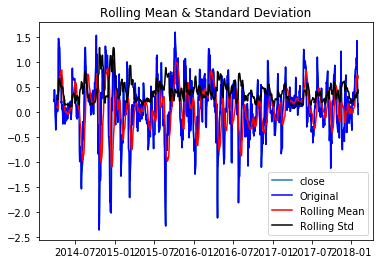

Results of Dickey-Fuller Test:
Test Statistic                -1.040076e+01
p-value                        1.912237e-18
#Lags Used                     7.000000e+00
Number of Observations Used    9.650000e+02
Critical Value (1%)           -3.437145e+00
Critical Value (5%)           -2.864540e+00
Critical Value (10%)          -2.568367e+00
dtype: float64


In [15]:
moving_avg = colaPrice.rolling(12).mean()
no_trend = colaPrice - moving_avg
plt.plot(no_trend)
plt.title("Coca-Cola Stock Data with Rolling Mean Removed")
test_stationarity(no_trend.dropna())

Figure 3 - Rolling Mean subtracted Coca-Cola Stock Prices. Dickey-Fuller Test was found to be statistically significant with 99% confidence.

Now with a lag of 7 we have a test statistic of -10.40 so we can reject the null hypothesis of our data not being stationary with 99% confidence, meaning our data is now stationary. However, looking at the red rolling mean line there still looks to be a trend. To get rid of this we can subtract the difference between each data point in the series and its previous data point to eliminate the remaining trends.

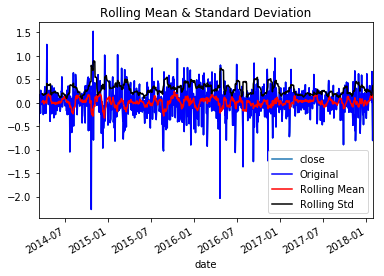

Results of Dickey-Fuller Test:
Test Statistic                 -31.668306
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    982.000000
Critical Value (1%)             -3.437027
Critical Value (5%)             -2.864488
Critical Value (10%)            -2.568340
dtype: float64


In [16]:
diff = colaPrice - colaPrice.shift()
diff.dropna(inplace=True)
diff.plot()
test_stationarity(diff)

Figure 4 - Differenced Coca-Cola Stock Prices. After subtracting off a rolling mean of 12 from the original time series, we also subtracted off each prior instance from the current instance. Dickey-Fuller Test was found to be statistically significant with 99% confidence.

Subtracting the shifted data from itself makes the test statistic for the Dickey-Fuller Test for stationary to jump to -31.67 making it extremely statistically significant. We will proceed with this differenced time series by analyzing its autocorrelation (ACF) and partial autocorrelation function (PACF) plots to choose appropriate AR (p) and MA (q) parameters for our ARIMA model. Once these parameters have been decided, we will fit our model to our undifferenced time series with a I (d) parameter of 1 since we needed to take the difference in our time series to eliminate these trends.

### Parameter estimation

Once our data passes the Dickey-Fuller test, we can use ARIMA to generate a model to predict the values $y(t)$ given $x(t)$. ARIMA has three main parameters that make up its name:

- AR (Auto-Regressive): The number of lagged terms used as a predictor for $x(t)$
    - $x(t) = alpha * x(t-1) + error(t)$
- I (Integration): The subtracting of an observation from an observation at the previous time point to make the time series stationary.
- MA (Moving Average): The number of lagged forecast errors as a predictor for $x(t)$
    - $x(t) = beta * e(t-1) + error(t)$

Another way of thinking about it is that AR terms change much slower and have a lingering effect. The MA term has a more instantanous effect and falls off quickly.

Each of ARIMA model components are represented by a parameter to tune. The parameters are only integers, a range of 0-4, and the standard notation is ARIMA(p, d, q) where each integer indicates what version of each model is used (AR, I, MA).

The parameters of the ARIMA model are defined as follows:

- p (AR): The number of lag observations included in the model, also called the lag order.
- d  (I): The number of times that the raw observations are differenced, also called the degree of differencing.
- q (MA): The size of the moving average window, also called the order of moving average.

#### Parameter selection rules

A series of rules was compiled by Dr. Robert Slater from many sources to help determine which parameter values should be used based upon visualizing Autocorrelation and Partial Autocorrelation Functions (ACF and PACF, respectively).

Rule's for determining $d$:
- Identifying the order of differencing and the constant:
    - Rule 1: If the series has positive autocorrelations out to a high number of lags (say, 10 or more), then it probably needs a higher order of differencing.
    - Rule 2: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING.
    - Rule 3: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest. (Not always, though. Slightly too much or slightly too little differencing can also be corrected with AR or MA terms. See rules 6 and 7.)
    - Rule 4: A model with no orders of differencing assumes that the original series is stationary (among other things, mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model).
    - Rule 5: A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend.

Rules for $p$ & $q$:
- Identifying the numbers of AR and MA terms:
    - Rule 6: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.
    - Rule 7: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.
    - Rule 8: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.
    - Rule 9: If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.
    - Rule 10: If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.
    - Rule 11: If the long-term forecasts* appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

#### Visual Estimation of $p$ & $q$ Parameters

To determine the values for $p$ & $q$, the ACF and PACF can be used. The ACF measures the correlation between a time instance and a lagged version of that time instance. In other words, how much influence do the previous $t-x$ values have on the value at time $t$. The PACF measures the correlation between a time instance after accounting for the ACF value.

Text(0.5, 1.0, 'Autocorrelation Function')

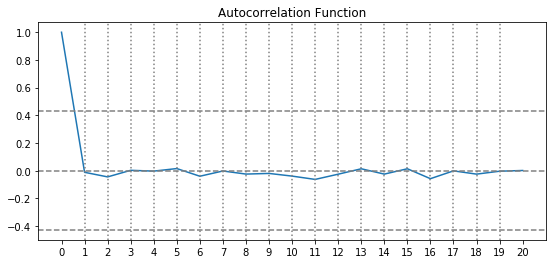

In [23]:
acf_price_plot = acf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_price_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_price_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_price_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

Figure 5 - Autocorrelation Function with Upper and Lower Confidence Intervals. A sharp cutoff can be seen to lag1 where the partial autocorelation remains at zero.

##### Estimating $d$ Value

- Rule 1: The autocorrelation drops to approximately zero suggesting no higher order of differencing needed
- Rule 2: The lag-1 autocorrelation is approximately zero suggesting it does not need a higher order of differencing. The value does not drop below -0.5 at lag-1 suggesting the data is not overdifferenced.

Looking at the autocorrelation function plot we can see that the autocorrelation dips to zero at lag-1 and remains at zero for practically every lag thereafter. This suggests rule 2 is in effect, meaning we do not need to use any more differencing than we had already done when subtracting a shift of 1 earlier in the analysis. If anything there might be overdifferencing might be in effect, but we cannot subtract a difference of less than 1.

##### Estimating $q$ Value

- Rule 7: The ACF displays a sharp cutoff at lag-1 suggesting a MA term should be applied.

Rule 7 applies to showing that we can add a MA (q) term.

Text(0.5, 1.0, 'Partial Autocorrelation Function')

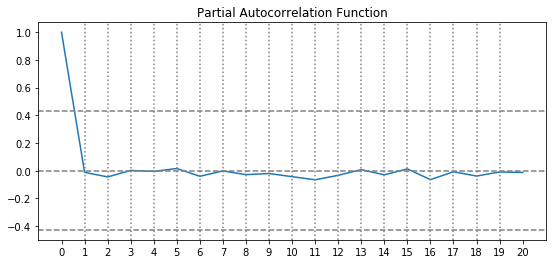

In [24]:
pacf_price_plot = pacf(diff.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_price_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_price_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_price_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

Figure 6 - Partial Autocorrelation Function with Upper and Lower Condidence Intervals. A sharp cutoff can be seen to lag1 where the partial autocorelation remains at zero.

#### Estimating $p$ Value

- Rule 6: The PACF displays a sharp cutoff at lag-1 suggesting an AR term should be applied.

Rule 6 also applies here meaning we should apply an AR (p) term.

#### Extra Considerations

- Rule 8: If the ACF and PACF graphs suggest an AR and MA term should be applied, we need to be cautious as the two terms can cancel each other out. Reducing the AR or MA term should be performed to assess the model performance.

Since Rule 8 states that AR and MA can cancel each other, we should pick a model with either a AR of 1 or MA of 1 with the other being 0.

Now that we've met ARIMA's assumptions and chosen our ARIMA parameters based upon rules to predict a correctly fit model we will fit two ARIMA models of AR (p)=0/1, I (d)=1, MA (q)=1/0 of our undifferenced model and choose the more accurate model between those two.

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  972
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -254.621
Method:                       css-mle   S.D. of innovations              0.314
Date:                Thu, 07 Mar 2019   AIC                            515.242
Time:                        23:48:15   BIC                            529.880
Sample:                             1   HQIC                           520.813
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0003      0.010     -0.029      0.977      -0.020       0.020
ar.L1.D.close     0.0046      0.032      0.144      0.885      -0.058       0.067
                                    Root

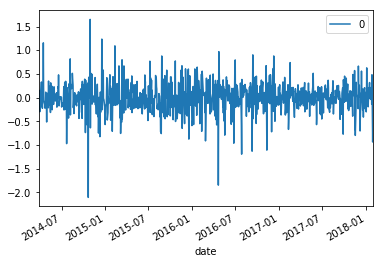

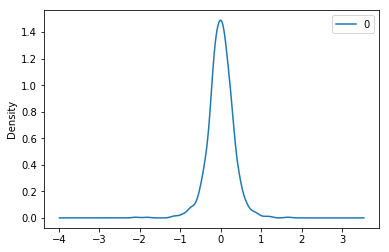

                  0
count  9.720000e+02
mean   1.322111e-07
std    3.145953e-01
min   -2.104753e+00
25%   -1.729944e-01
50%   -3.636210e-03
75%    1.851892e-01
max    1.650754e+00


In [17]:
model = ARIMA(no_trend.dropna(), order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
print("")
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Figure 7 - Manually selected ARIMA parameters model #1, (1,1,0). AIC score of 515.24. Residuals are distributed normally around zero.

The above model with AR (p) = 1, I (d) = 1, and MA (q) = 0 has a AIC (akaike information criterion) value of 515.24. Our residuals follow a normal distrubtion and are farily small outside several outliers. We will now try a model of AR (p) = 0, I (d) = 1, and MA (q) = 1 to see which is more accurate.

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  982
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -287.588
Method:                       css-mle   S.D. of innovations              0.323
Date:                Thu, 07 Mar 2019   AIC                            581.175
Time:                        23:48:24   BIC                            595.844
Sample:                             1   HQIC                           586.755
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.766e-06   3.63e-05      0.159      0.874   -6.54e-05     7.7e-05
ma.L1.D.close    -1.0000      0.003   -363.040      0.000      -1.005      -0.995
                                    Root

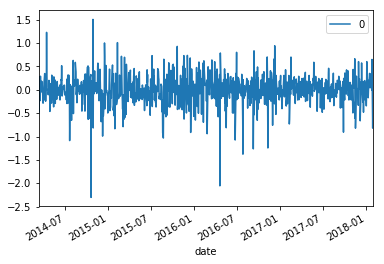

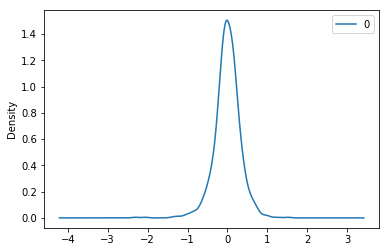

                0
count  982.000000
mean    -0.003789
std      0.324207
min     -2.303072
25%     -0.169172
50%     -0.001050
75%      0.177397
max      1.507918


In [18]:
model = ARIMA(diff.dropna(), order=(0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Figure 8 - Manually selected ARIMA parameters model #2, (0,1,1). AIC score of 581.18. Residuals are distributed normally around zero.

This model yielded more error (AIC = 581.18), meaning we will stick to our first model of (1,0,0) that had an AIC of 515.24.

### Gridsearch for $p$, $q$, and $d$

Due to the limited range of values each parameter can take (0-3 for d and q, and 0-4 for p) and the computation time required to evaluate a model, we can apply a gridsearch method to arrive at the best possible combination for parameter values. This will iterate through every combination of parameters and give an error metric so we can decide which model is most accurate. However, the rules of ARIMA must still be kept in mind to prevent overfitting. Most notably being since AR and MA actually cancel each other out, it would overfit the model if both are allowed to be greater than 1. We will use these rules to eliminate overfit models that will have very low AIC scores.

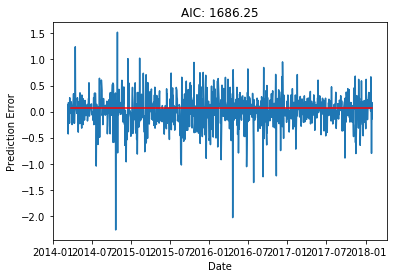

ARIMA Model #1 - Parameters: (p = 0, d = 0, q = 0)


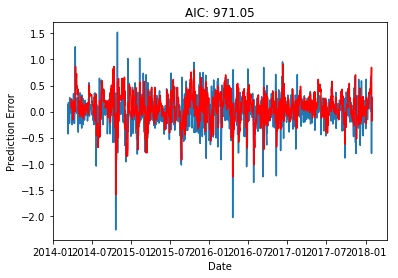

ARIMA Model #2 - Parameters: (p = 0, d = 0, q = 1)


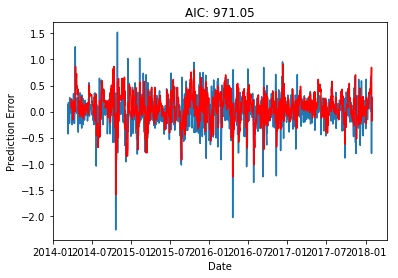

ARIMA Model #3 - Parameters: (p = 0, d = 0, q = 2)


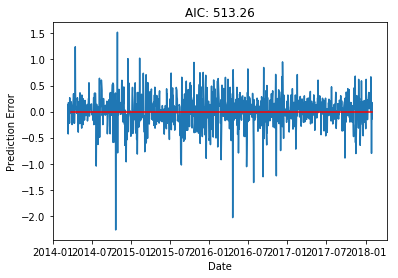

ARIMA Model #4 - Parameters: (p = 0, d = 1, q = 0)


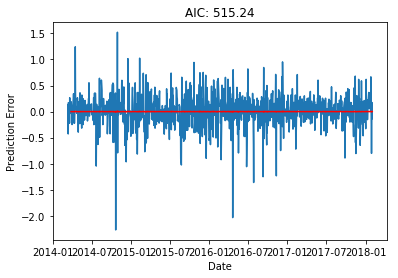

ARIMA Model #5 - Parameters: (p = 0, d = 1, q = 1)


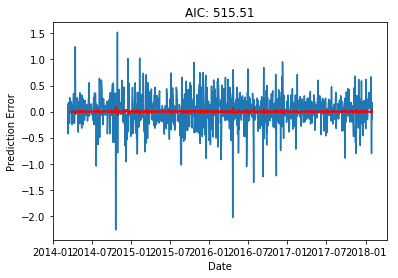

ARIMA Model #6 - Parameters: (p = 0, d = 1, q = 2)


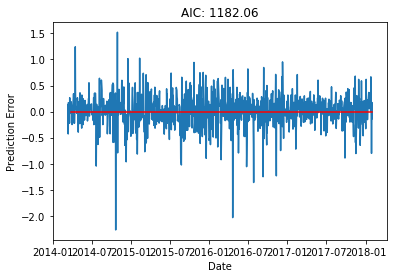

ARIMA Model #7 - Parameters: (p = 0, d = 2, q = 0)


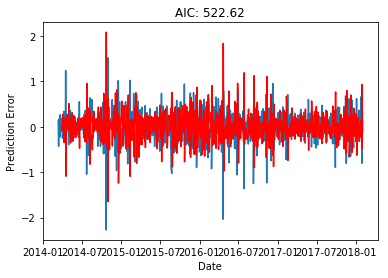

ARIMA Model #8 - Parameters: (p = 0, d = 2, q = 1)


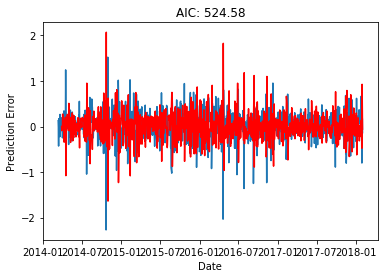

ARIMA Model #9 - Parameters: (p = 0, d = 2, q = 2)


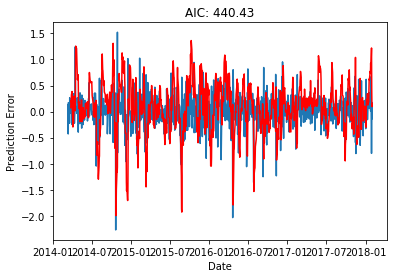

ARIMA Model #10 - Parameters: (p = 1, d = 0, q = 0)


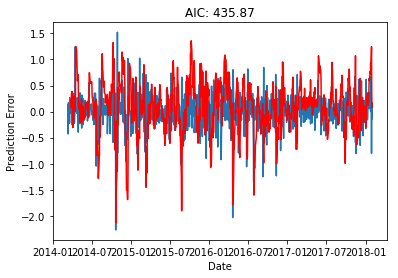

ARIMA Model #11 - Parameters: (p = 1, d = 0, q = 1)


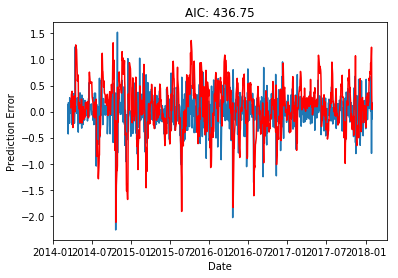

ARIMA Model #12 - Parameters: (p = 1, d = 0, q = 2)


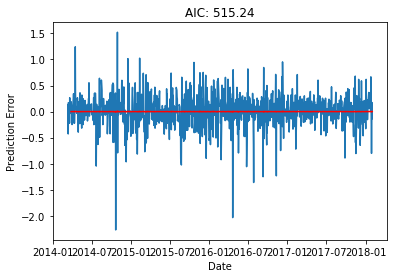

ARIMA Model #13 - Parameters: (p = 1, d = 1, q = 0)


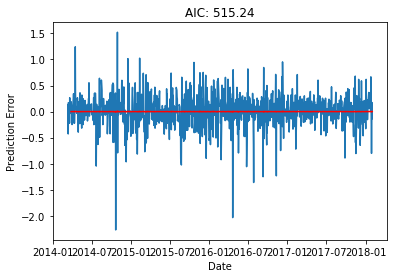

ARIMA Model #14 - Parameters: (p = 1, d = 1, q = 1)


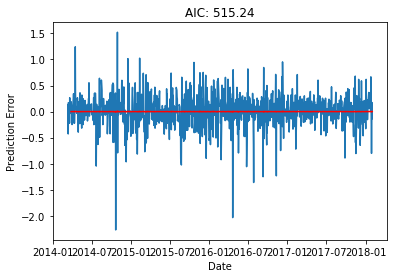

ARIMA Model #15 - Parameters: (p = 1, d = 1, q = 2)


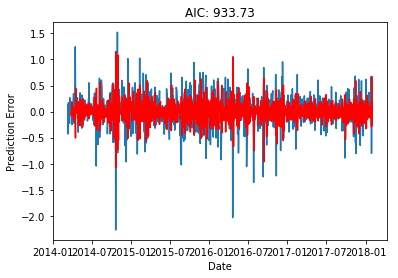

ARIMA Model #16 - Parameters: (p = 1, d = 2, q = 0)


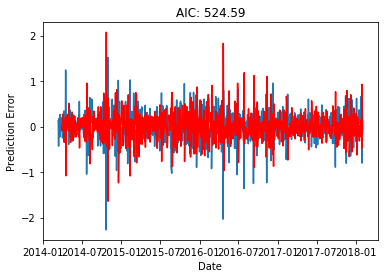

ARIMA Model #17 - Parameters: (p = 1, d = 2, q = 1)


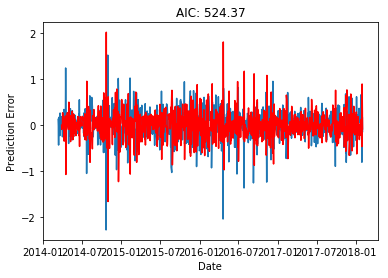

ARIMA Model #18 - Parameters: (p = 1, d = 2, q = 2)


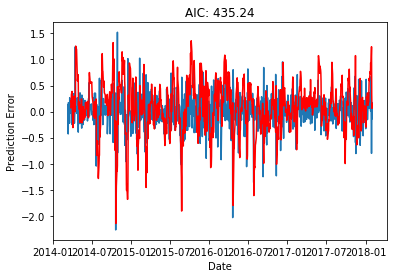

ARIMA Model #19 - Parameters: (p = 2, d = 0, q = 0)


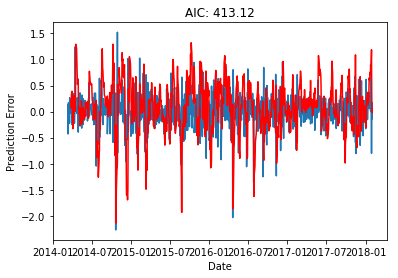

ARIMA Model #20 - Parameters: (p = 2, d = 0, q = 1)


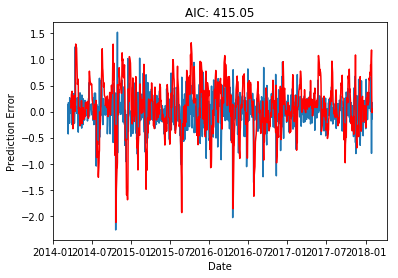

ARIMA Model #21 - Parameters: (p = 2, d = 0, q = 2)


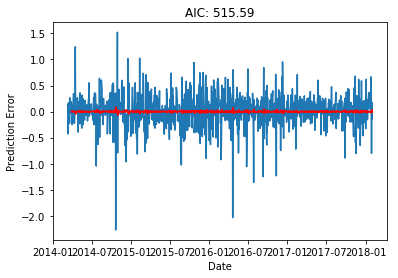

ARIMA Model #22 - Parameters: (p = 2, d = 1, q = 0)


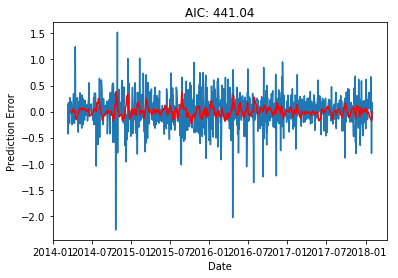

ARIMA Model #23 - Parameters: (p = 2, d = 1, q = 1)


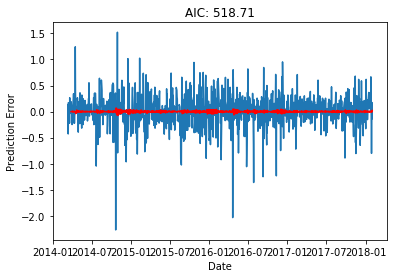

ARIMA Model #24 - Parameters: (p = 2, d = 1, q = 2)


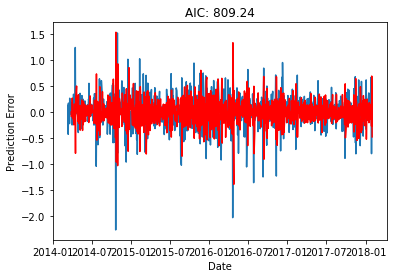

ARIMA Model #25 - Parameters: (p = 2, d = 2, q = 0)


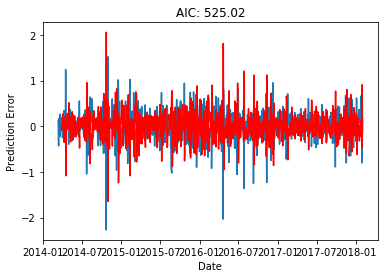

ARIMA Model #26 - Parameters: (p = 2, d = 2, q = 1)


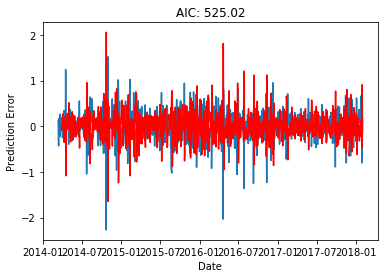

ARIMA Model #27 - Parameters: (p = 2, d = 2, q = 2)


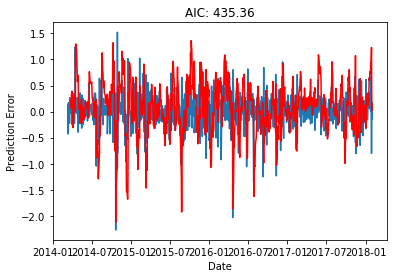

ARIMA Model #28 - Parameters: (p = 3, d = 0, q = 0)


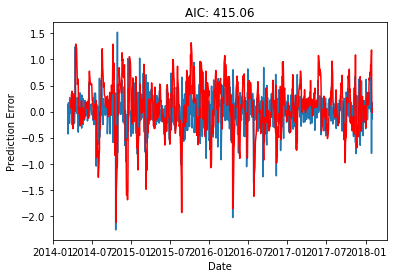

ARIMA Model #29 - Parameters: (p = 3, d = 0, q = 1)


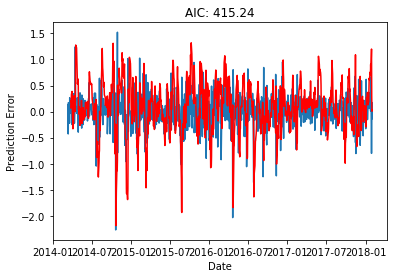

ARIMA Model #30 - Parameters: (p = 3, d = 0, q = 2)


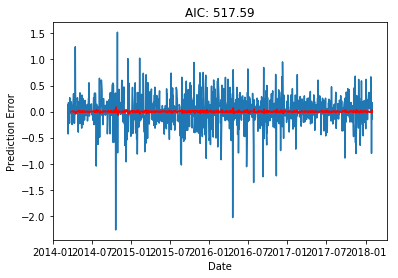

ARIMA Model #31 - Parameters: (p = 3, d = 1, q = 0)


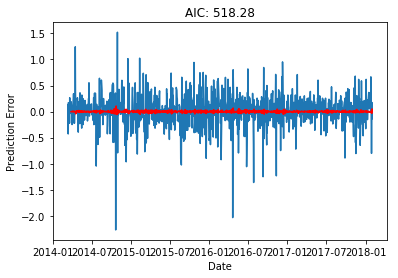

ARIMA Model #32 - Parameters: (p = 3, d = 1, q = 1)


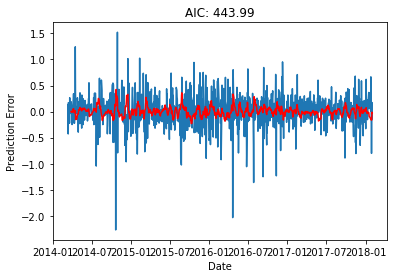

ARIMA Model #33 - Parameters: (p = 3, d = 1, q = 2)


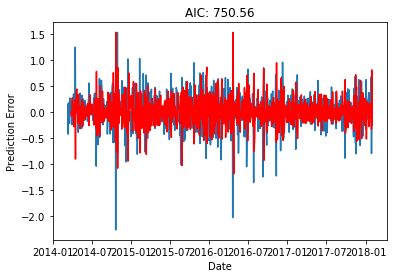

ARIMA Model #34 - Parameters: (p = 3, d = 2, q = 0)


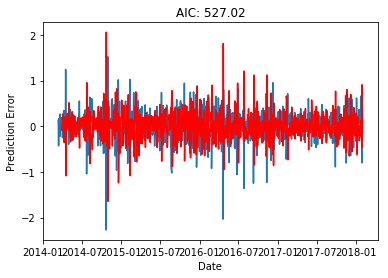

ARIMA Model #35 - Parameters: (p = 3, d = 2, q = 1)


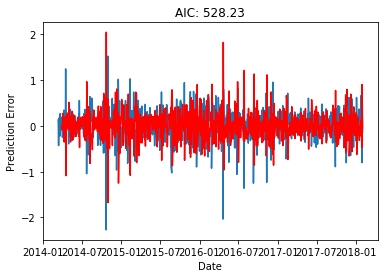

ARIMA Model #36 - Parameters: (p = 3, d = 2, q = 2)


In [19]:
colaPrice = colaPrice.astype(float)
loss_best = 1E16
best_ints = [-1,-1,-1]
z = 1
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(no_trend.dropna(), order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.xlabel("Date")
            plt.ylabel("Prediction Error")
            plt.title(f"AIC: {results_ARIMA.aic:.2f}")
            if loss < loss_best:
                #print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(f"ARIMA Model #{z} - Parameters: (p = {p}, d = {d}, q = {q})")
            z += 1
            
            #print(p,d,q)
            #print(f"AIC: {results_ARIMA.aic}")
            #print(f"BIC: {results_ARIMA.bic}")

Figure 9 - GridSearch results of ARIMA models. 36 models were ran with every combination of p,d,q parameters and their corresponding AIC scores.

Based on the gridsearch performed, the model that performed best was $p = 2$, $d = 0$, and $q = 1$. This model was able to acheive a AIC of 413.1. This is a combination that we would not have likely found manually since we had placed our d=1. Which means we indeed might have overdifferenced even with a d of 1 and our gridsearch found the optimal p and q parameters without the differencing. This does not violate our ARIMA rule either where only one of p and q can be greater than 1. For a model that included a d of 1 (that did not violate ARIMA rules) the best model was $p = 2$, $d = 1$, and $q = 1$ with an AIC of 441.0.

# Results

From our manually selected parameters we chose a model of (1,1,0) to give us an AIC of 515.2. We chose a differencing of 1 due to our time series looking like it still had trends in the data even though it had passed the Dickey-Fuller Test. Having a difference of 1 did not yield an optimal model when we used a gridsearch approach however. We found the most optimal parameter settings were (2,0,1) with an AIC of 413.1, beating our manually selected model by 102.1 AIC. This is a very big difference in AIC and shows our manually selected model was overdifferenced. All parameter combinations and their AIC scores from the can be seen in Figure 10.

| $p$ | $d$ | $q$ |  AIC  |
|:-:|:-:|:-:|:-----:|
| 2 | 0 | 1 | 413.1 |
| 2 | 0 | 2 | 415.1 |
| 3 | 0 | 1 | 415.1 |
| 3 | 0 | 2 | 415.2 |
| 2 | 0 | 0 | 435.2 |
| 3 | 0 | 0 | 435.4 |
| 1 | 0 | 1 | 435.9 |
| 1 | 0 | 2 | 436.8 |
| 1 | 0 | 0 | 440.4 |
| 2 | 1 | 1 | 441.0 |
| 3 | 1 | 2 | 444.0 |
| 0 | 1 | 0 | 513.3 |
| 0 | 1 | 1 | 515.2 |
| 1 | 1 | 0 | 515.2 |
| 1 | 1 | 1 | 515.2 |
| 1 | 1 | 2 | 515.2 |
| 0 | 1 | 2 | 515.5 |
| 2 | 1 | 0 | 515.6 |
| 3 | 1 | 0 | 517.6 |
| 3 | 1 | 1 | 518.3 |
| 2 | 1 | 2 | 518.7 |
| 0 | 2 | 1 | 522.6 |
| 1 | 2 | 2 | 524.4 |
| 0 | 2 | 2 | 524.6 |
| 1 | 2 | 1 | 524.6 |
| 2 | 2 | 1 | 525.0 |
| 2 | 2 | 2 | 525.0 |
| 3 | 2 | 1 | 527.0 |
| 3 | 2 | 2 | 528.2 |
| 3 | 2 | 0 | 750.6 |
| 2 | 2 | 0 | 809.2 |
| 1 | 2 | 0 | 933.7 |
| 0 | 0 | 1 | 971.1 |
| 0 | 0 | 2 | 971.1 |
| 0 | 2 | 0 | 1182  |
| 0 | 0 | 0 | 1686  |

Figure 10 - ARIMA GridSearch parameter combinations and AIC scores. The optimal model of 2,0,1 had an AIC of 413.1 was mostly followed by several overfit models with AIC scores of 415.

# Discussion

Even when trends look apparent, we should trust the Dickey-Fuller Test when significance is found for the stationary assumption required for ARIMA. We found our manually selected model was in fact overdifferenced when we tried to subtract out these trends with a difference of 1 after utilizing gridsearch to find the optimal model. Also it is interesting how the most accurate model (2,0,1) found by our gridsearch did not violate the ARIMA rules. We assumed beforehand that our gridsearch would find the most overfit model by violating ARIMA rules to implement high values of AR (p) and MA (q) but this was not the case for the Coca-Cola data. While ARIMA is not a very good prediction/forcasting tool for future instances, it would suffice for a forecast of one or two instances ahead in time.

#### References

- http://people.duke.edu/~rnau/411arim.htm
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- http://www.sthda.com/english/articles/38-regression-model-validation/158-regression-model-accuracy-metrics-r-square-aic-bic-cp-and-more/
- https://www.sciencedirect.com/science/article/pii/S2212977414000064

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

# Credit: Professor Slater
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    print(dfoutput)

start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 2, 1)
colaPrice = web.DataReader('KO', 'iex', start, end)['close']
colaPrice.index = pd.to_datetime(colaPrice.index)

5y
